In [1]:
import pandas as pd
import seaborn as sns
import os
import glob
import tqdm
import matplotlib.pyplot as plt

In [2]:
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 1.5)

In [3]:
root = '/home/csvt32745/matte/MaskPropagation/vm108_val_midtri_1024x576'
models = os.listdir(root)
names, frames = zip(*[(k.rsplit('_mem', maxsplit=1)) for k in models if '_mem' in k])
names = list(set(names))
frames = sorted([int(i[:-1]) for i in list(set(frames))])

In [4]:
# TODO: select some models only
names = [i for i in names if 'STCN' not in i]
names

['TCVOM_GCA_TAM',
 'GFM_GatedFuseVM_3dtvloss_weightce_512',
 'GFM_GatedFuseVM_temp_cons',
 'ft_TCVOM_GCA_TAM',
 'GFM_GatedFuseVM_2dtv_tempcons_weightce_512',
 'DualVM']

In [5]:
dfs = {}
for m in tqdm.tqdm(names):
    dfs[m] = []
    for f in frames:
        n = f'{m}_mem{f}f'
        p = os.path.join(root, n, n+'.xlsx')
        if os.path.isfile(p):
            dfs[m].append(pd.read_excel(p, sheet_name=None))
        else:
            dfs[m].append(None)
    dfs[m].append(pd.read_excel(os.path.join(root, m, m+'.xlsx'), sheet_name=None))

100%|██████████| 6/6 [02:09<00:00, 21.64s/it]


In [6]:
def format_df(df):
    df = df.iloc[1:]
    df = df[df.columns[1:]]
    # format name
    col_names = df.columns.to_list()
    col_names[0] = 'clip'
    col_names[1] = 'avg'
    df.columns = col_names
    df['avg'] = df[df.columns[2:]].mean(axis=1)
    return df

In [9]:
for m in dfs.keys():
    for i in range(len(frames)+1):
        if dfs[m][i] is None:
            continue
        if 'summary' in dfs[m][i].keys():
            dfs[m][i].pop('summary')
        for k in dfs[m][i].keys():
            dfs[m][i][k] = format_df(dfs[m][i][k])

In [8]:
import numpy as np

In [10]:
model = next(iter(dfs))
metric_dfs = {}
avg_dfs = {}
index = None
for model in dfs.keys():
    if index is None:
        metrics = [k for k in dfs[model][-1].keys() if 'fgr' not in k]
        index = dfs[model][-1]['pha_mad'].index

    metric_dfs_ = {}
    avg_ = {}
    for metric in metrics:
        avg_df = {}
        for i, f in enumerate(frames):
            if dfs[model][i] is None:
                # avg_df[f'mem{f}f'] = dfs[model][-1][metric]['avg']#.replace({'*': np.nan})
                continue
            avg_df[f'mem{f}f'] = dfs[model][i][metric]['avg']
        avg_df['first_only'] = dfs[model][-1][metric]['avg']
        df = pd.DataFrame(avg_df)
        df.index = index
        metric_dfs_[metric] = df
        avg_[metric] = df.mean()
    metric_dfs[model] = metric_dfs_
    avg_dfs[model] = pd.DataFrame(avg_)

In [11]:
avg_dfs[next(iter(metric_dfs))]

,pha_mad,pha_mse,pha_grad,pha_conn,pha_dtssd
mem30f,38.913324,22.843017,9.278248,22.595546,4.500075
mem60f,48.020899,30.108751,10.969906,28.145971,4.510819
mem120f,56.247759,36.698968,12.738860,33.173430,4.581950
mem240f,66.381744,44.991927,14.852729,39.332862,4.661383
mem480f,79.063155,55.959307,16.128150,46.977994,4.628669
first_only,96.487252,71.004265,18.754332,57.524401,4.688493


In [12]:
metrics

['pha_mad', 'pha_mse', 'pha_grad', 'pha_conn', 'pha_dtssd']

In [13]:
names

['TCVOM_GCA_TAM',
 'GFM_GatedFuseVM_3dtvloss_weightce_512',
 'GFM_GatedFuseVM_temp_cons',
 'ft_TCVOM_GCA_TAM',
 'GFM_GatedFuseVM_2dtv_tempcons_weightce_512',
 'DualVM']

In [66]:
name_dict = {
    'DualVM': 'DualVM',
    'GFM_GatedFuseVM_3dtvloss_weightce_512': 'GFM GatedFuseVM',
    'TCVOM_GCA_TAM': 'TCVOM',
    'ft_TCVOM_GCA_TAM': 'TCVOM Finetune',
}

In [32]:
def sort_time(df):
    time_order = [f'mem{f}f' for f in frames] + ['first_only']
    # df[column] = pd.Categorical(df[column], time_order)
    # df = df.sort_values(column)
    return df.reindex(time_order)

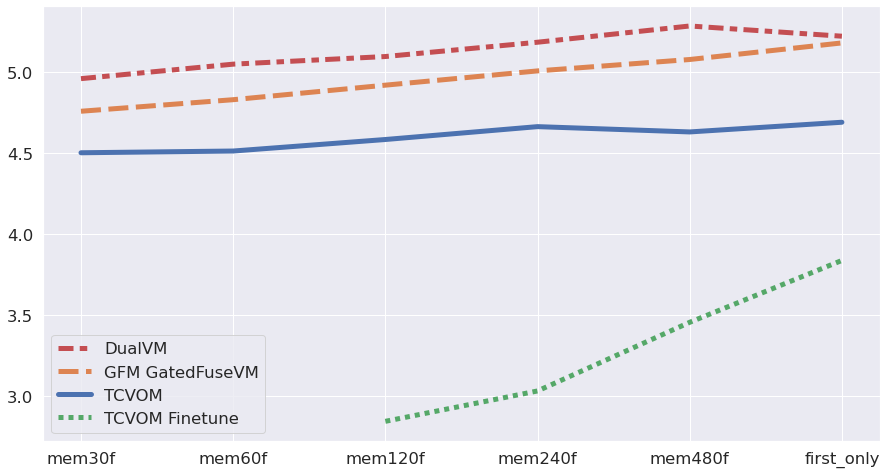

In [70]:
metric = 'pha_dtssd'
df = pd.DataFrame({name_dict[k]: v[metric] for k, v in avg_dfs.items() if k in name_dict})
# df = pd.DataFrame({name_dict[k]: v[metric] for k, v in avg_dfs.items()})
df = sort_time(df)
lp = sns.lineplot(data=df, linewidth=5)
d = {l:h for h, l in zip(*lp.get_legend_handles_labels())}
h, l = zip(*[(d[k], k) for k in name_dict.values()])
for leg in lp.legend(h, l).get_lines():
    leg.set_linewidth(5)

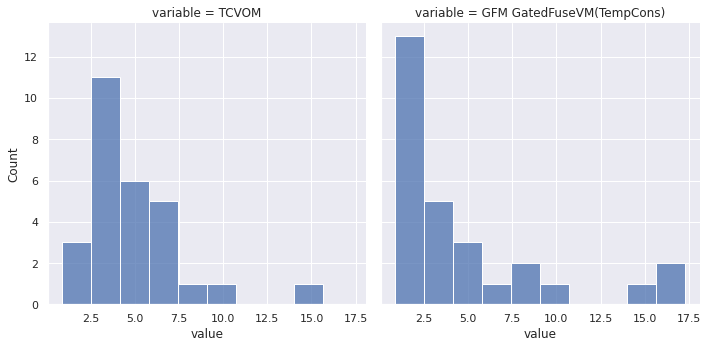

In [ ]:
def plot_hist(score):
    df = score.melt(value_vars=score.columns).dropna()
    sns.displot(data=df, col='variable', x='value', multiple='dodge', bins=10)
    sns.set(rc={'figure.figsize':(8, 8)})
    # sns.set_context(
    #     # "notebook", 
    #     font_scale=2, 
    #     rc={"lines.linewidth": 2, 'figure.figsize':(26,18)}
    # )
df = pd.DataFrame({
    'TCVOM': metric_dfs['TCVOM_GCA_TAM']['pha_dtssd']['mem30f'],
    'GFM GatedFuseVM(TempCons)': metric_dfs['GFM_GatedFuseVM_temp_cons']['pha_dtssd']['mem30f']
})
plot_hist(df)

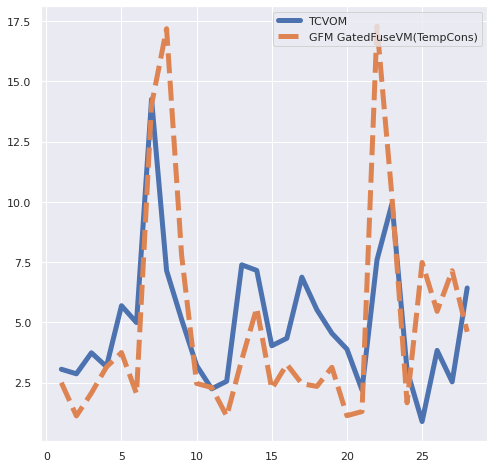

In [ ]:
lp = sns.lineplot(data=df, linewidth=5)
for leg in lp.legend().get_lines():
    leg.set_linewidth(5)